In [1]:
import cv2
import numpy as np
import os
from scipy.interpolate import interp1d
# from sklearn.decomposition import PCA
from pyefd import elliptic_fourier_descriptors
# from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# import pickle

In [2]:
%matplotlib inline

In [24]:
# All Requirdef read_images_and_extract_contours_single_image(img_location):

'''
# Old one with Loop

def read_images_and_extract_contours_single_image(img_location):
    """Read images from a folder and extract their largest external contour."""
    images = img_location
    contours_list = []
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            contour = contour.squeeze()
            contours_list.append(normalize_contour_points(contour))
    return contours_list
'''

def read_image_and_extract_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions
        return normalize_contour_points(contour)
    else:
        return None  # Return None if no contours are found

def normalize_contour_points(contour):
    """Normalize contour points to a fixed number for consistency."""
    N = 250
    contour_length = np.linspace(0, 1, len(contour))
    normalized_length = np.linspace(0, 1, N)
    interp_func_x = interp1d(contour_length, contour[:, 0], kind='linear')
    interp_func_y = interp1d(contour_length, contour[:, 1], kind='linear')
    normalized_contour = np.vstack((interp_func_x(normalized_length), interp_func_y(normalized_length))).T
    return normalized_contour

def compute_first_10_harmonics(contour, order=30):
    """Compute Fourier coefficients and return the first 10 harmonics."""
    coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
    first_10_harmonics = coeffs[:10]  # Extract the first 10 harmonics
    return first_10_harmonics

def show_image(image_path):
    """Display an image."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_image)
    plt.title(image_path)
    plt.axis('off')
    plt.show()


def plot_harmonic_distribution(harmonics):
    """Plot the distribution of the first 10 harmonic or coefficients as magnitudes."""
    # Compute magnitudes for each harmonic (A_n, B_n, C_n, D_n)
    magnitudes = np.linalg.norm(harmonics, axis=1)  # Calculate sqrt(A_n^2 + B_n^2 + C_n^2 + D_n^2)
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    harmonic_indices = np.arange(1, len(magnitudes) + 1)
    plt.bar(harmonic_indices, magnitudes, color='skyblue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Harmonic Number')
    plt.ylabel('Magnitude')
    plt.title('Distribution of the First 10 Harmonics')
    plt.xticks(harmonic_indices)

    # Show the plot
    plt.show()


def compute_S_only_positive(harmonics, m, epsilon=1e-10):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    epsilon: a small constant to ensure positive magnitudes (default: 1e-10).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(1, 11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        
        # Compute the magnitude of the harmonic, ensuring it's positive
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Ensure the magnitude is positive by adding a small epsilon if needed
        magnitude = np.abs(magnitude) + epsilon
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S

def calculate_separator_suggested_change(efd_coeffs, m=3):
    # Extract the first 10 harmonics (assuming 4 coefficients per harmonic)
    first_10_harmonics = efd_coeffs[:10]

    # Calculate magnitudes for each harmonic (A, B, C, D)
    magnitudes = np.sqrt(np.sum(np.square(first_10_harmonics), axis=1))  # Compute magnitude for each harmonic

    # Generate harmonic indices, starting from 1 to 10
    harmonic_indices = np.arange(1, 11)

    # Calculate the separator value (sum of weighted magnitudes)
    separator_value = np.sum(magnitudes * np.power(harmonic_indices, m))

    return separator_value


In [26]:
# This section just visualizes the extracted contours

# old code that reads the image as for loop
# def read_image_and_visualize_contour(img_location):
#     """Read images from a folder and extract their largest external contour."""
#     images = img_location
#     contours_list = []
#     for image_path in images:
#         image = cv2.imread(image_path)
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
#         contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#         if contours:
#             # Find the largest contour
#             contour = max(contours, key=cv2.contourArea)
#             contour = contour.squeeze()  # Remove unnecessary dimensions
#             contours_list.append(normalize_contour_points(contour))
#             # Visualize the contour on the original image
#             visualize_contour(image, contour)
#     return contours_list


def read_image_and_visualize_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    contours_list = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions

        # Normalize the contour points
        normalized_contour = normalize_contour_points(contour)

        # Append the normalized contour to the list
        contours_list.append(normalized_contour)

        # Visualize the contour on the original image
        visualize_contour(image, normalized_contour)

    return contours_list

def visualize_contour(image, contour):
    """Visualize the contour on the image using matplotlib."""
    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image_rgb)
    
    # Plot the contour on the image
    plt.plot(contour[:, 0], contour[:, 1], color='red', linewidth=2)  # Red contour line
    
    plt.title("Extracted Contour")
    plt.axis('off')  # Hide axes
    plt.show()

def normalize_contour_points(contour):
    """Normalize contour points for visualization (optional)."""
    # This function could be useful for contour normalization
    # Example: Scaling or translating points to some standard size
    return contour

# Test Case 1: Good Potato

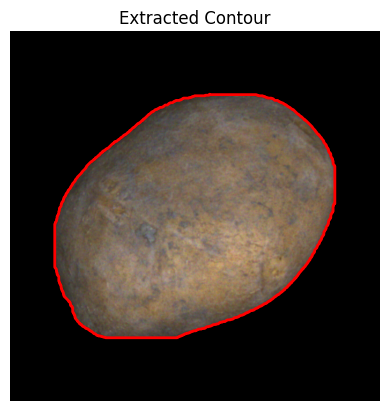

[array([[345, 109],
        [344, 110],
        [343, 110],
        ...,
        [348, 109],
        [347, 109],
        [346, 109]], dtype=int32)]

In [28]:
case_1 = '/home/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_2_class/good/Afra_12_2_1_110_9.png'

read_image_and_visualize_contour(case_1)

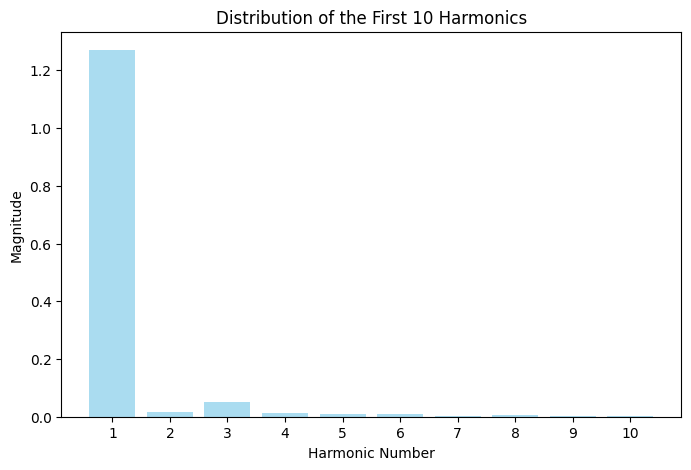

In [23]:
# Read Image & Extract Contour -> Compute 10 Harmonics -> Visualize Plot -> Calculate Separator S

# Extract contours from the image
contours_case_1 = read_image_and_extract_contour(case_1)

# Compute the first 10 harmonics
harmonics_case_1 = compute_first_10_harmonics(contours_case_1)

# Plot the harmonic distribution
plot_harmonic_distribution(harmonics_case_1)

In [7]:
# Calculate the separator S for both function

print(f"Separator Value with compute_S_only_positive: {compute_S_only_positive(harmonics_case_1, m=3)}")

print(f"Separator Value with calculate_separator_suggested_change: {calculate_separator_suggested_change(harmonics_case_1, m=3)}")

Separator Value with compute_S_only_positive: 15.772595334273678
Separator Value with calculate_separator_suggested_change: 15.77259503177368


# Test Case 2: Bottleneck Potato

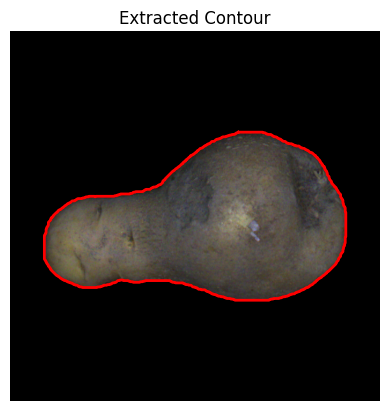

[array([[395, 174],
        [394, 175],
        [393, 175],
        ...,
        [398, 174],
        [397, 174],
        [396, 174]], dtype=int32)]

In [8]:
case_2 = '/home/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/bottleneck/sd_malformed_12_2_1_100_10.png'

read_image_and_visualize_contour(case_2)

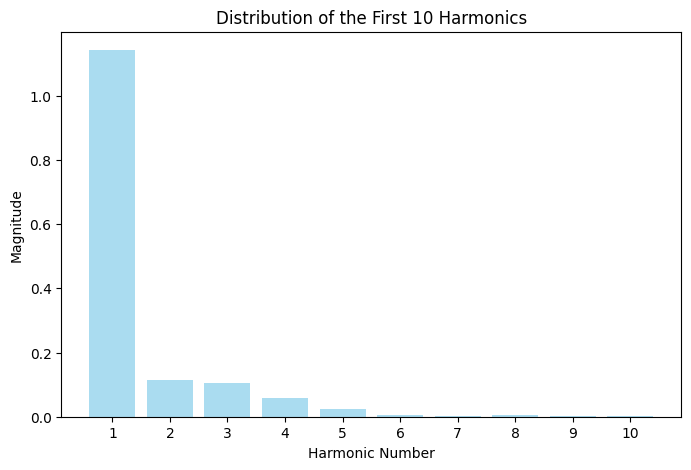

In [9]:
# Read Image & Extract Contour -> Compute 10 Harmonics -> Visualize Plot -> Calculate Separator S

# Extract contours from the image
contours_case_2 = read_image_and_extract_contour([case_2])[0]

# Compute the first 10 harmonics
harmonics_case_2 = compute_first_10_harmonics(contours_case_2)

# Plot the harmonic distribution
plot_harmonic_distribution(harmonics_case_2)

In [10]:
# Calculate the separator S for both function

print(f"Separator Value with compute_S_only_positive: {compute_S_only_positive(harmonics_case_2, m=3)}")

print(f"Separator Value with calculate_separator_suggested_change: {calculate_separator_suggested_change(harmonics_case_2, m=3)}")

Separator Value with compute_S_only_positive: 19.771019521721882
Separator Value with calculate_separator_suggested_change: 19.771019219221888


# Test Case 3: Potato with Bloop

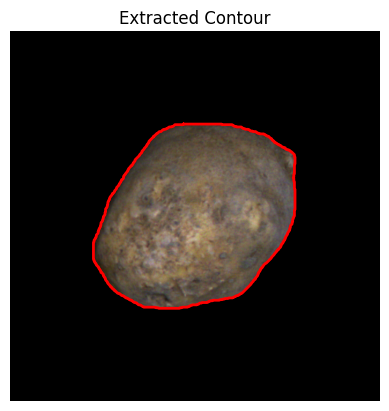

[array([[300, 160],
        [299, 161],
        [298, 161],
        ...,
        [303, 160],
        [302, 160],
        [301, 160]], dtype=int32)]

In [11]:
case_3 = '/home/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/good/Afra_12_2_1_104_8.png'

read_image_and_visualize_contour(case_3)

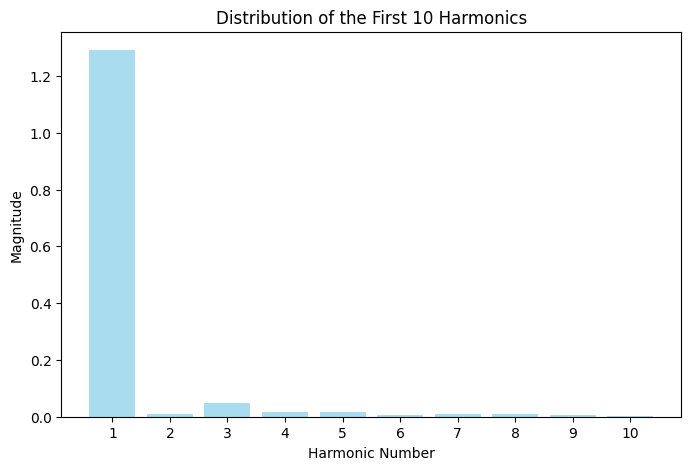

In [12]:
# Read Image & Extract Contour -> Compute 10 Harmonics -> Visualize Plot -> Calculate Separator S

# Extract contours from the image
contours_case_3 = read_image_and_extract_contour([case_3])[0]

# Compute the first 10 harmonics
harmonics_case_3 = compute_first_10_harmonics(contours_case_3)

# Plot the harmonic distribution
plot_harmonic_distribution(harmonics_case_3)

In [13]:
# Calculate the separator S for both function

print(f"Separator Value with compute_S_only_positive: {compute_S_only_positive(harmonics_case_3, m=3)}")

print(f"Separator Value with calculate_separator_suggested_change: {calculate_separator_suggested_change(harmonics_case_3, m=3)}")

Separator Value with compute_S_only_positive: 23.992989545205525
Separator Value with calculate_separator_suggested_change: 23.992989242705523


# Case 4: Ginger

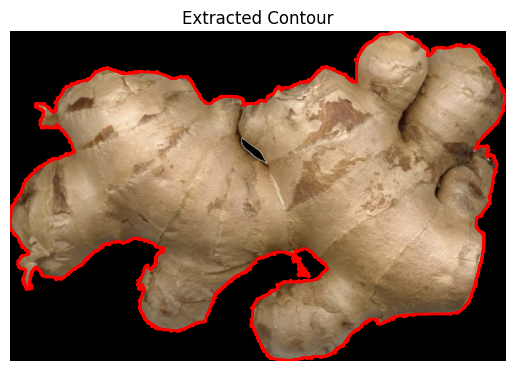

[array([[1234,    0],
        [1234,    1],
        [1233,    2],
        ...,
        [1237,    0],
        [1236,    0],
        [1235,    1]], dtype=int32)]

In [19]:
case_4 = '/home/mishkat/Documents/malformed_potato/Fourier_Related/ginger_on_black.jpg'

read_image_and_visualize_contour(case_4)

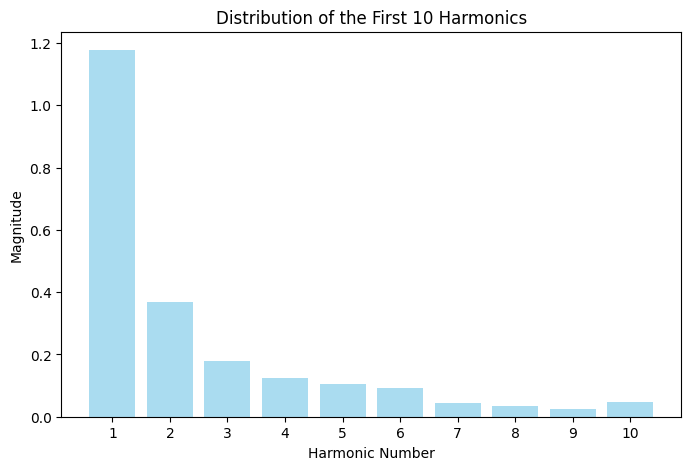

In [20]:
# Read Image & Extract Contour -> Compute 10 Harmonics -> Visualize Plot -> Calculate Separator S

# Extract contours from the image
contours_case_4 = read_image_and_extract_contour([case_4])[0]

# Compute the first 10 harmonics
harmonics_case_4 = compute_first_10_harmonics(contours_case_4)

# Plot the harmonic distribution
plot_harmonic_distribution(harmonics_case_4)

In [21]:
# Calculate the separator S for both function

print(f"Separator Value with compute_S_only_positive: {compute_S_only_positive(harmonics_case_4, m=3)}")

print(f"Separator Value with calculate_separator_suggested_change: {calculate_separator_suggested_change(harmonics_case_4, m=3)}")

Separator Value with compute_S_only_positive: 148.76514797318055
Separator Value with calculate_separator_suggested_change: 148.76514767068056
